<a href="https://colab.research.google.com/github/lasyaEd/computerVision/blob/main/ACVTask1HandBuiltCNN%26Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##After manually uploading my Kaggle API Key

In [ ]:
import os
import zipfile

# Make a directory for Kaggle API key
os.makedirs("/root/.kaggle", exist_ok=True)

# Move uploaded kaggle.json to the correct location
!mv kaggle.json /root/.kaggle/

# Set correct permissions
!chmod 600 /root/.kaggle/kaggle.json

# Verify Kaggle is configured correctly
!kaggle datasets list


ref                                                                    title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
atharvasoundankar/chocolate-sales                                      Chocolate Sales Data 📊🍫                             14KB  2025-03-19 03:51:40           7817        127  1.0              
adilshamim8/student-depression-dataset                                 Student Depression Dataset                         456KB  2025-03-13 03:12:30           1449         28  1.0              
abdulmalik1518/mobiles-dataset-2025                                    Mobiles Dataset (2025)                              20KB  2025-02-18 06:50:24          14233        253  1.0              
atharvasoundankar/global-water

##Download & Extract Dataset

In [ ]:
# Download dataset
!kaggle datasets download -d gti-upm/leapgestrecog

# Extract the dataset
with zipfile.ZipFile("leapgestrecog.zip", "r") as zip_ref:
    zip_ref.extractall(".")

# Check extracted files
!ls leapGestRecog


Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.12G/2.13G [00:20<00:00, 128MB/s]
100% 2.13G/2.13G [00:20<00:00, 113MB/s]
00  01	02  03	04  05	06  07	08  09


##Keep Only Numbered Directories (Remove Unnecessary Files)

In [ ]:
import shutil

# Remove unnecessary duplicate folder if it exists
if os.path.exists("leapGestRecog/leapGestRecog"):
    shutil.rmtree("leapGestRecog/leapGestRecog")

# List the required directories (should be numbers 0-9)
print("Remaining folders inside leapGestRecog:")
print(os.listdir("leapGestRecog"))


Remaining folders inside leapGestRecog:
['01', '08', '09', '04', '03', '00', '05', '07', '02', '06']


##Import required Libraries

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

##Define the HandGestureDataset Class

In [ ]:
class HandGestureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Get numbered directories (00, 01, ..., 09)
        for folder in sorted(os.listdir(root_dir)):
            folder_path = os.path.join(root_dir, folder)

            if os.path.isdir(folder_path):  # Ensure it's a directory
                for gesture_folder in os.listdir(folder_path):
                    gesture_path = os.path.join(folder_path, gesture_folder)
                    if os.path.isdir(gesture_path):
                        image_files = glob(os.path.join(gesture_path, "*.png"))

                        # Store images & corresponding labels
                        self.image_paths.extend(image_files)
                        self.labels.extend([int(folder)] * len(image_files))  # Assign label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image in grayscale mode
        image = Image.open(img_path).convert("L")

        if self.transform:
            image = self.transform(image)

        return image, label

##Define Image Transformations

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale image
])

##Create Dataset & DataLoader Instances

In [ ]:
# Define dataset path
dataset_path = "/content/leapGestRecog"  # Adjusted to match Colab directory

# Create dataset instance
gesture_dataset = HandGestureDataset(root_dir=dataset_path, transform=image_transforms)

# Create DataLoader for batching
gesture_loader = DataLoader(gesture_dataset, batch_size=32, shuffle=True)

# Print dataset size
print(f"Total dataset size: {len(gesture_dataset)} images")

Total dataset size: 20000 images


##Modify Dataset Class for Splitting

In [ ]:
from sklearn.model_selection import train_test_split

class HandGestureDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image in grayscale mode
        image = Image.open(img_path).convert("L")

        if self.transform:
            image = self.transform(image)

        return image, label

##Split Dataset into Train & Test Sets

In [ ]:
# Get all image paths and labels
all_image_paths = gesture_dataset.image_paths
all_labels = gesture_dataset.labels

# Split into Train (80%) and Test (20%) sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Create Train & Test Dataset instances
train_dataset = HandGestureDataset(train_paths, train_labels, transform=image_transforms)
test_dataset = HandGestureDataset(test_paths, test_labels, transform=image_transforms)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Train Dataset Size: {len(train_dataset)} images")
print(f"Test Dataset Size: {len(test_dataset)} images")

Train Dataset Size: 16000 images
Test Dataset Size: 4000 images


##Print a Few Images and Associated Labels

###Load a Batch of Images from the Train Set

In [ ]:
# Get a batch of images and labels from the train DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)  # Fetch first batch


###Display Images with Labels

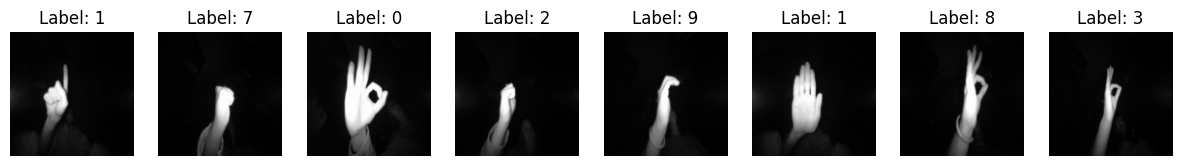

In [ ]:
import matplotlib.pyplot as plt

# Function to display a batch of images
def show_images(images, labels, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        img = images[i].squeeze(0).numpy()  # Remove channel dimension (Grayscale)
        label = labels[i].item()  # Convert tensor to int

        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.show()

# Show sample images
show_images(images, labels)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

##VGG-style CNN

In [ ]:
class HandGestureCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(HandGestureCNN, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.3)  # Dropout to prevent overfitting

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))

        x = torch.flatten(x, 1)  # Flatten before fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

###Instantiate and Summarize the Model

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model and move to GPU if available
model = HandGestureCNN(num_classes=10).to(device)

# Print model summary
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8          [-1, 128, 32, 32]             256
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Linear-10                  [-1, 256]       8,388,864
          Dropout-11                  [-1, 256]               0
           Linear-12                   [-1, 10]           2,570
Total params: 8,484,554
Trainable params: 8,484,554
Non-trainable params: 0
---------------------------

**Where to Apply Dropout?**

We applied Dropout (0.3) before the last fully connected layer because:

Dropout in Convolutional Layers is uncommon since spatial feature learning is crucial.
FC layers have more parameters, so Dropout reduces overfitting.
0.3 probability was chosen to balance regularization without losing too much information.

**Did We Use Other Model Enhancements?**

Yes! We applied:

Batch Normalization: Normalizes activations to stabilize training.
Max Pooling: Reduces feature map size, making the model efficient.

**How Did We Design the Classification Layer?**

Flattened the feature maps from Conv layers.
Fully connected layers (fc1 and fc2) process the feature vector.
Softmax is applied implicitly in CrossEntropyLoss, so we don’t need it in forward().

In [ ]:
import time

# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training Phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = correct_train / total_train
        history["train_loss"].append(train_loss / len(train_loader))
        history["train_acc"].append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(val_accuracy)

        # Adjust learning rate
        scheduler.step(val_loss)

        # Print progress
        end_time = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss / len(train_loader):.4f} | Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss / len(val_loader):.4f} | Val Acc: {val_accuracy:.4f} "
              f"Time: {end_time - start_time:.2f}s")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_gesture_model.pth")

    return history


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Evaluation function
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:\n", classification_report(all_labels, all_preds))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
history = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=15)

# Plot training history
plot_training_history(history)


NameError: name 'criterion' is not defined

In [ ]:
evaluate_model(model, test_loader)

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    plt.show()
